In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

## 데이터 생성 및 시각화

In [2]:
# 2차원 데이터
n_dim = 2
# 샘플 데이터를 만들어주는 함수
x_train, y_train = make_blobs(
    n_samples=80, n_features=n_dim,
    centers=[[0,0],[1,1],[1,0],[0,1]],
    shuffle=True, cluster_std=0.15
)
x_test, y_test = make_blobs(
    n_samples=20, n_features=n_dim,
    centers=[[0,0],[1,1],[1,0],[0,1]],
    shuffle=True, cluster_std=0.15
)

In [3]:
# 데이터 초반부 훑어보기
for x, y in list(zip(x_train, y_train))[:10]:
    print(f'x: {str(x):30} y: {y}')

x: [0.81285497 0.07608161]        y: 2
x: [0.89513741 0.85795686]        y: 1
x: [-0.10727313  0.0584729 ]      y: 0
x: [-0.06266637  1.19437139]      y: 3
x: [ 0.09531442 -0.36850896]      y: 0
x: [0.85809865 0.95638773]        y: 1
x: [-0.10015598  0.6804442 ]      y: 3
x: [ 0.24654902 -0.13345357]      y: 0
x: [ 0.9365965  -0.31223501]      y: 2
x: [1.03411052 0.9750699 ]        y: 1


In [4]:
# 이진 분류를 할 것이므로 생성한 데이터의 0,1번 클래스는 0으로, 2,3번 클래스는 1로 재설정
label_dict = {
    0:0, 1:0,
    2:1, 3:1
}
y_train = np.vectorize(lambda l: label_dict[l])(y_train)
y_test = np.vectorize(lambda l: label_dict[l])(y_test)

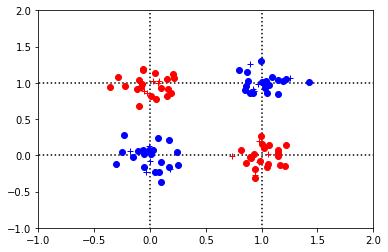

In [5]:
def draw(x, y, style='o'):
    for x_, y_ in zip(x,y):
        plt.plot(x_[0], x_[1], 'b'+style if y_ == 0 else 'r'+style)

plt.figure()
# 데이터 생성 기준선
plt.hlines(0, -2, 2, color='k', linestyles=':')
plt.hlines(1, -2, 2, color='k', linestyles=':')
plt.vlines(0, -2, 2, color='k', linestyles=':')
plt.vlines(1, -2, 2, color='k', linestyles=':')
# 학습 데이터는 원, 테스트데이터는 십자, 클래스 0은 파랑, 클래스 1은 빨강으로 표시
draw(x_train, y_train, 'o')
draw(x_test, y_test, '+')
plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.show()

## Pytorch에서 사용하기 위해 Tensor로 변환

In [18]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])


In [7]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(NeuralNet, self).__init__()
            self.input_dim = input_dim
            self.hidden_dim  = hidden_dim
            
            ##################################################################
            self.layer1 = torch.nn.Linear(self.input_dim, self.hidden_dim)
            self.layer2 = torch.nn.Linear(self.hidden_dim, 1)
            self.relu = torch.nn.ReLU()
            self.sigmoid = torch.nn.Sigmoid()
            ##################################################################
            
        def forward(self, x):
            ##################################################################
            x = self.layer1(x)
            x = self.relu(x)
            x = self.layer2(x)
            x = self.sigmoid(x)
            ##################################################################
            return x 

In [8]:
learning_rate = 3e-2
epochs = 2000
model = NeuralNet(2, 5)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [9]:
model(torch.tensor([0.1,0.1]))

tensor([0.4856], grad_fn=<SigmoidBackward0>)

In [10]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3806,  0.1528],
         [ 0.4764,  0.3332],
         [-0.4138, -0.3825],
         [ 0.2219,  0.1408],
         [-0.5753,  0.3719]], requires_grad=True),
 Parameter containing:
 tensor([-0.5649,  0.3167, -0.3452, -0.1412,  0.1239], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2234,  0.3385,  0.3073, -0.1301, -0.1544]], requires_grad=True),
 Parameter containing:
 tensor([-0.1761], requires_grad=True)]

In [11]:
[p.grad for p in model.parameters()]

[None, None, None, None]

In [12]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7003147602081299


In [13]:
model.train()
optimizer.zero_grad()
train_output = model(x_train)
train_loss = criterion(train_output.squeeze(), y_train)
train_loss.backward()
optimizer.step()

In [14]:
import os
path = './ckpt'
if not os.path.isdir(path):
    os.mkdir(path)

In [15]:
for epoch in range(0, epochs+1):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print(f'{epoch:<4} | Train loss: {train_loss.item():.6f}')
        torch.save(model.state_dict(), './ckpt/model_epoch{}.pt'.format(epoch))
    train_loss.backward()
    optimizer.step()

0    | Train loss: 0.700487


In [197]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.2600817084312439


In [198]:
torch.save(model.state_dict(), './ckpt/model.pt')
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-1.4647, -1.2714],
                      [-0.1764,  0.2228],
                      [ 0.2142,  1.5889],
                      [-1.7974,  1.5136],
                      [ 0.8125, -0.1187]])),
             ('layer1.bias',
              tensor([ 1.1937, -0.3160,  0.2591, -0.0355,  0.4900])),
             ('layer2.weight',
              tensor([[-2.1642, -0.1945, -1.1619,  2.2475,  0.6995]])),
             ('layer2.bias', tensor([0.4420]))])

In [199]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./ckpt/model.pt'))
new_model.eval()
print('벡터 [0, 1]의 레이블은?')
print(new_model(torch.FloatTensor([0,1])).item())

벡터 [0, 1]의 레이블은?
0.8672293424606323


In [200]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred)).squeeze()
    
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100).item()
    return acc

In [201]:
new_model.eval()
print(torch.round(new_model(x_test)).squeeze())
print(y_test)
print(binary_acc(new_model(x_test), y_test))

tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 1.], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 1.])
100.0


In [202]:
for i in range(0, epochs+1, 100):
    new_model = NeuralNet(2, 5)
    new_model.load_state_dict(torch.load('./ckpt/model_epoch{}.pt'.format(i)))
    new_model.eval()
    print(f'Epoch {i:<4} | Test Accuracy: {binary_acc(new_model(x_test), y_test)}%')

Epoch 0    | Test Accuracy: 35.0%
Epoch 100  | Test Accuracy: 30.0%
Epoch 200  | Test Accuracy: 35.0%
Epoch 300  | Test Accuracy: 45.0%
Epoch 400  | Test Accuracy: 50.0%
Epoch 500  | Test Accuracy: 50.0%
Epoch 600  | Test Accuracy: 50.0%
Epoch 700  | Test Accuracy: 65.0%
Epoch 800  | Test Accuracy: 70.0%
Epoch 900  | Test Accuracy: 70.0%
Epoch 1000 | Test Accuracy: 70.0%
Epoch 1100 | Test Accuracy: 70.0%
Epoch 1200 | Test Accuracy: 75.0%
Epoch 1300 | Test Accuracy: 75.0%
Epoch 1400 | Test Accuracy: 80.0%
Epoch 1500 | Test Accuracy: 95.0%
Epoch 1600 | Test Accuracy: 100.0%
Epoch 1700 | Test Accuracy: 100.0%
Epoch 1800 | Test Accuracy: 100.0%
Epoch 1900 | Test Accuracy: 100.0%
Epoch 2000 | Test Accuracy: 100.0%
